In [30]:
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch import nn
import numpy as np
import torch


In [31]:
preprocess = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)
batch_size = 32
dataset = MNIST(root='', train=True, download=True, transform=preprocess)
loader_train = DataLoader(dataset, batch_size, shuffle=True, )

Input shape: torch.Size([1, 1, 28, 28])
Output shape: torch.Size([1, 1, 28, 28])


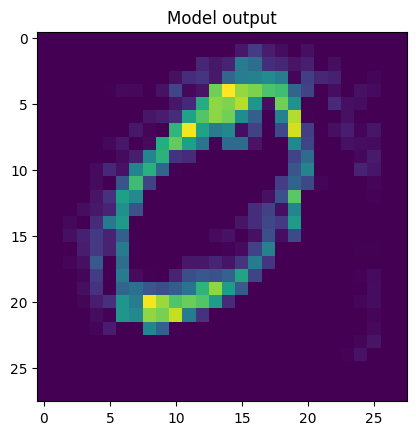

In [36]:
class ConvBlock(nn.Module):
    '''Convolutional block for U-Net encoder and decoder'''
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels,out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels,out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.conv(x)

class DownBlock(nn.Module):
    '''Down sampling ResNet block'''
    def __init__(self, in_channels,out_channels):
        super().__init__()
        self.conv_block = ConvBlock(in_channels, out_channels)
        self.maxpool = nn.MaxPool2d(2)
    
    def forward(self, x):
        skip_connection = self.conv_block(x)
        x = self.maxpool(skip_connection)
        return x, skip_connection
    
    
class UpBlock(nn.Module):
    '''Up sampling ResNet block'''
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, in_channels, 2, stride=2)
        self.conv_block = ConvBlock(2*in_channels, out_channels)
    def forward(self, x, skip_conn):
        x = self.deconv(x)
        x = torch.cat([x, skip_conn], dim=1)
        return self.conv_block(x)
    
    
class UNet(nn.Module):
    '''UNet based on ResNet architecture'''
    def __init__(self, in_channels=1, out_channels=1, block_out_channels=[128, 256, 512]):
        '''Initialize a UNet model.
        in_channels: channels of input images.
        out_channels: channels of output images.
        block_out_channels: number of channels as output of each UNet convolotional block.'''
        super().__init__()
        assert len(block_out_channels)>=1
        # Intitialize encoder list and decoder list
        self.encoder = nn.ModuleList()
        self.encoder.append(DownBlock(in_channels, block_out_channels[0]))
        self.decoder = nn.ModuleList()
        self.decoder.append(UpBlock(block_out_channels[0], out_channels))
        self.neck = ConvBlock(block_out_channels[-1], block_out_channels[-1])
        for i in range(len(block_out_channels)-1):
            self.encoder.append(DownBlock(block_out_channels[i], block_out_channels[i + 1]))
            self.decoder.insert(0, UpBlock(block_out_channels[i+1],block_out_channels[i]))
    
    def forward(self, x):
        skip_connections = []
        for down_block in self.encoder:
            x, w = down_block(x)
            skip_connections.append(w)
        x = self.neck(x)
        for w, up_block in zip(skip_connections[::-1], self.decoder):
            x = up_block(x,w)
        return x

model = UNet(in_channels=1, out_channels=1, block_out_channels=[128,256])

sample_image = dataset[1][0].unsqueeze(0)
print("Input shape:", sample_image.shape)

print("Output shape:", model(sample_image).shape)
plt.imshow(model(sample_image).squeeze().detach().numpy())
plt.title("Model output")
plt.show()